# Imports, device and seeding

In [21]:
# --- Standard libs ---
import os
import math
import random
from dataclasses import dataclass
from typing import Dict, Any

# --- Scientific stack ---
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- ACORL and RL ---
from acorl.envs.seeker.seeker import SeekerEnv, SeekerEnvConfig

# --- Own Code ---
from MCTS import MCTSPlanner
from network import SeekerAlphaZeroNet
from utils import (
    ReplayBufferHybrid,
    collect_one_episode_hybrid,
    train_step_mle,
    train_step_mcts_distill,
    train_step_hybrid,
    run_eval_episodes,
    run_debug_eval_episode,
)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# --- Reproducibility ---
def set_global_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


SEED = 42
set_global_seeds(SEED)

Using device: cpu


# Config

## baseline config
### Comments are explaining what each parameter does in general, but also mixed with comments that explain behavious of this specific configuration

In [22]:
@dataclass
class Config:
    # ========================
    # Environment
    # ========================
    max_episode_steps: int = 200

    # ========================
    # MCTS core
    # ========================
    num_simulations: int = 200    # Number of MCTS simulations per real environment step
    cpuct: float = 1.5            # Exploration vs exploitation tradeoff in PUCT; Higher -> more exploration guided by policy prior
    gamma_mcts: float = 0.99           # Discount factor for return backup in MCTS
    max_depth: int = 64           # Safety cap on tree depth during a simulation

    # For root action selection / Action sampling temperature at root
    # >1.0 = more stochastic, 1.0 = proportional to visits, ~0 = greedy
    temperature: float = 1.0

    # ========================
    # Progressive Widening
    # ========================
    pw_k: float = 2.0
    # Controls how many actions are allowed per node:
    #   K_max = pw_k * N(s)^pw_alpha
    pw_alpha: float = 0.5
    # Growth rate of branching factor
    # 0.5 is common; smaller = more conservative expansion

    # ========================
    # Action sampling (baseline, non-fancy, but no duplicates)
    # ========================
    # --- Uniform warmstart ---
    # No uniform warmstart, no diversity scoring
    K_uniform_per_node: int = 8
    # First K children per node are sampled uniformly in [-1,1]^2
    # Set to 0 to disable
    warmstart_iters: int = 20
    # Number of *training iterations* during which ALL nodes use uniform sampling
    # 0 disables global warmstart; use this if you want uniform sampling only early in training

    # --- Novelty reject (hard deduplication) ---
    # Deduplicate actions (keep this ON to satisfy “no duplicate actions”)
    novelty_eps: float = 1e-3      # small but > 0
    # Minimum distance between actions to be considered "new"
    # In [-1,1]^2, values around 0.05–0.15 are reasonable
    # Set <=0 to disable
    novelty_metric: str = "l2"
    # Distance metric for novelty check:
    # "linf" = max(|dx|, |dy|)  (good for box action spaces)
    # "l2"   = Euclidean distance

    # --- Diversity scoring (soft repulsion) ---
    # Disable candidate scoring / diversity
    num_candidates: int = 1
    # Number of candidate actions sampled before choosing the best
    # <=1 disables diversity scoring
    diversity_lambda: float = 0.0
    # Strength of diversity penalty
    # Higher -> stronger push away from already-sampled actions
    # Set <=0 to disable
    diversity_sigma: float = 0.25  # unused
    # Length scale for diversity penalty
    # Roughly: how far actions must be before they stop "repelling" each other
    policy_beta: float = 1.0       # unused
    # Weight of policy log-probability in candidate scoring
    # Higher -> follow policy more closely
    # Lower -> prioritize diversity more

    # --- Resampling control ---
    max_resample_attempts: int = 16
    # How many times expansion may retry to find a novel action
    # If all fail, expansion is declined and MCTS falls back to selection
    
    # ========================
    # Training
    # ========================
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-4
    train_steps_per_iter: int = 200    # Gradient updates per outer iteration

    # (Only used by our baseline loss function)
    value_loss_weight: float = 1.0
    policy_loss_weight: float = 1.0  # applies to mu/log_std regression

    # ========================
    # Data collection
    # ========================
    episodes_per_iter: int = 10     # Number of real env episodes collected per training iteration
    replay_buffer_capacity: int = 50_000
    gamma_mc = 0.9

    # ========================
    # Logging / evaluation
    # ========================
    eval_every: int = 5
    eval_episodes: int = 10   # use 10 fixed seeds for smoother eval curves


cfg = Config()


## Sanity test

In [23]:
from pprint import pprint
pprint(cfg)

Config(max_episode_steps=200,
       num_simulations=200,
       cpuct=1.5,
       gamma_mcts=0.99,
       max_depth=64,
       temperature=1.0,
       pw_k=2.0,
       pw_alpha=0.5,
       K_uniform_per_node=8,
       warmstart_iters=20,
       novelty_eps=0.001,
       novelty_metric='l2',
       num_candidates=1,
       diversity_lambda=0.0,
       diversity_sigma=0.25,
       policy_beta=1.0,
       max_resample_attempts=16,
       batch_size=128,
       learning_rate=0.0003,
       weight_decay=0.0001,
       train_steps_per_iter=200,
       value_loss_weight=1.0,
       policy_loss_weight=1.0,
       episodes_per_iter=10,
       replay_buffer_capacity=50000,
       eval_every=5,
       eval_episodes=10)


# Create env_real, env_sim, dims (for network), and step_fn (for MCTSPlanner)

In [24]:
EVAL_SEEDS = list(range(1000, 1000 + cfg.eval_episodes))  # fixed "validation set"

# --- Env config ---
env_config = SeekerEnvConfig(randomize=True, num_obstacles=1)

# --- Real environment for rollouts / data collection ---
env_real = SeekerEnv(**env_config.model_dump(exclude={"id"}))
obs0, info0 = env_real.reset()

obs_dim = env_real.observation_space.shape[0]
action_dim = env_real.action_space.shape[0]

print("obs_dim:", obs_dim, "action_dim:", action_dim)
print("action_space:", env_real.action_space)

# --- Simulation environment for MCTS step_fn ---
env_sim = SeekerEnv(**env_config.model_dump(exclude={"id"}))

# --- evaluation environment for evaluation during training ---
env_eval = SeekerEnv(**env_config.model_dump(exclude={"id"}))


def set_env_state_from_obs(sim_env: SeekerEnv, obs: np.ndarray):
    """
    Overwrite SeekerEnv internal state to match the flat observation vector.

    obs layout (from your old notebook):
      [agent_x, agent_y, goal_x, goal_y, (obs_x, obs_y, obs_r)*N]
    """
    obs = np.asarray(obs, dtype=sim_env._dtype)

    # agent and goal
    sim_env._agent_position = obs[0:2].copy()
    sim_env._goal_position = obs[2:4].copy()

    # obstacles
    obstacles = obs[4:].reshape(-1, 3)
    sim_env._obstacle_position = obstacles[:, 0:2].copy()
    sim_env._obstacle_radius = obstacles[:, 2].copy()

def step_fn(state: np.ndarray, action: np.ndarray):
    """
    MCTS transition function: set env_sim to `state`, take `action`, return next_state/reward/done/info.
    Returns: next_state, reward, done, info  (matching MCTSPlanner expectations)
    """
    set_env_state_from_obs(env_sim, state)

    action = np.asarray(action, dtype=env_sim._dtype)
    next_obs, reward, terminated, truncated, info = env_sim.step(action)
    done = bool(terminated or truncated)

    return next_obs, float(reward), done, info

obs_dim: 7 action_dim: 2
action_space: Box(-1.0, 1.0, (2,), float64)


# Instantiate neural network and optimizer

In [25]:
# --- Network ---
net = SeekerAlphaZeroNet(obs_dim=obs_dim, action_dim=action_dim).to(device)

# Optional: print one forward pass sanity
obs_t = torch.from_numpy(obs0).float().unsqueeze(0).to(device)
with torch.no_grad():
    mu_t, log_std_t, v_t = net(obs_t)

print("mu:", mu_t.cpu().numpy())
print("log_std:", log_std_t.cpu().numpy())
print("v:", v_t.item())

# --- Optimizer (we'll use later) ---
optimizer = optim.AdamW(net.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

mu: [[-0.26337135 -0.13172348]]
log_std: [[ 0.45294833 -0.14332369]]
v: 0.02973608300089836


# Instantiate MCTSPlanner

In [26]:
planner = MCTSPlanner(
    net=net,
    device=str(device),
    step_fn=step_fn,
    num_simulations=cfg.num_simulations,
    cpuct=cfg.cpuct,
    gamma=cfg.gamma_mcts,
    pw_k=cfg.pw_k,
    pw_alpha=cfg.pw_alpha,
    max_depth=cfg.max_depth,
    temperature=cfg.temperature,
    rng=np.random.default_rng(SEED),
    
    K_uniform_per_node=cfg.K_uniform_per_node,
    warmstart_iters=cfg.warmstart_iters,
    novelty_eps=cfg.novelty_eps,
    novelty_metric=cfg.novelty_metric,
    num_candidates=cfg.num_candidates,
    diversity_lambda=cfg.diversity_lambda,
    diversity_sigma=cfg.diversity_sigma,
    policy_beta=cfg.policy_beta,
    max_resample_attempts=cfg.max_resample_attempts,
)

# Smoke test: one MCTS search, inspect root, pick action, step env_real

In [27]:
# Reset real env
obs, info = env_real.reset()

# Run one MCTS search from the current observation
root = planner.search(obs)

print("Root visit count N:", root.N)
print("Root children K:", len(root.children))

# Show a few children stats
for i, ch in enumerate(root.children[:5]):
    print(
        f"[{i}] N_sa={ch.N_sa:4d}  Q_sa={ch.Q_sa:+.4f}  "
        f"P_raw={ch.P_sa_raw:.3e}  P={ch.P_sa:.3f}  action={ch.action}"
    )

# Pick an action from MCTS policy (training=True samples from visit counts)
action = planner.act(root, training=True)
print("Chosen action:", action)

# Step the real environment once
next_obs, reward, terminated, truncated, info = env_real.step(action)
done = bool(terminated or truncated)

print("Step result -> reward:", reward, "done:", done)
print("Obs delta L2:", np.linalg.norm(next_obs - obs))


Root visit count N: 200
Root children K: 29
[0] N_sa=   5  Q_sa=-21.3346  P_raw=1.123e-01  P=0.044  action=[ 0.5479121  -0.12224312]
[1] N_sa=   3  Q_sa=-33.9120  P_raw=8.752e-02  P=0.035  action=[0.71719587 0.39473605]
[2] N_sa=   4  Q_sa=-2.7142  P_raw=4.341e-02  P=0.017  action=[-0.8116453  0.9512447]
[3] N_sa=   6  Q_sa=-17.9681  P_raw=7.721e-02  P=0.031  action=[0.5222794 0.5721286]
[4] N_sa=  11  Q_sa=-2.6866  P_raw=5.583e-02  P=0.022  action=[-0.25840396  0.85353   ]
Chosen action: [-0.06088838 -0.6210573 ]
Step result -> reward: -0.9035175975254326 done: False
Obs delta L2: 0.6240348783470926


In [28]:
# Show all children stats
for i, ch in enumerate(root.children):
    print(
        f"[{i}] N_sa={ch.N_sa:4d}  Q_sa={ch.Q_sa:+.4f}  "
        f"P_raw={ch.P_sa_raw:.3e}  P={ch.P_sa:.3f}  action={ch.action}"
    )

actions = np.stack([ch.action for ch in root.children], axis=0)
print("unique rows:", np.unique(actions, axis=0).shape[0], " / ", actions.shape[0])

[0] N_sa=   5  Q_sa=-21.3346  P_raw=1.123e-01  P=0.044  action=[ 0.5479121  -0.12224312]
[1] N_sa=   3  Q_sa=-33.9120  P_raw=8.752e-02  P=0.035  action=[0.71719587 0.39473605]
[2] N_sa=   4  Q_sa=-2.7142  P_raw=4.341e-02  P=0.017  action=[-0.8116453  0.9512447]
[3] N_sa=   6  Q_sa=-17.9681  P_raw=7.721e-02  P=0.031  action=[0.5222794 0.5721286]
[4] N_sa=  11  Q_sa=-2.6866  P_raw=5.583e-02  P=0.022  action=[-0.25840396  0.85353   ]
[5] N_sa=  21  Q_sa=-2.6812  P_raw=1.026e-01  P=0.041  action=[-0.1131716 -0.5455226]
[6] N_sa=   2  Q_sa=-50.0328  P_raw=1.100e-01  P=0.044  action=[ 0.5161755  -0.29094806]
[7] N_sa=   6  Q_sa=-18.4197  P_raw=7.088e-02  P=0.028  action=[-0.066558  -0.9123925]
[8] N_sa=  17  Q_sa=-8.2274  P_raw=9.686e-02  P=0.038  action=[-0.06088838 -0.6210573 ]
[9] N_sa=   2  Q_sa=-50.1219  P_raw=1.090e-01  P=0.043  action=[ 0.4005302  -0.37526673]
[10] N_sa=   9  Q_sa=-12.9035  P_raw=9.534e-02  P=0.038  action=[0.5738488  0.32970172]
[11] N_sa=  16  Q_sa=-2.6647  P_raw=8.

# Tests

## plotting functions

In [29]:
def decode_obs(obs):
    obs = np.asarray(obs)
    agent = obs[0:2]
    goal = obs[2:4]
    obstacles_flat = obs[4:]
    num_obstacles = len(obstacles_flat)//3
    obstacles = obstacles_flat.reshape(num_obstacles, 3)  # (x, y, r) per obstacle
    return agent, goal, obstacles

def plot_seeker_obs(obs, info, title=None):
    agent, goal, obstacles = decode_obs(obs)
    L = info.get("boundary_size", 10)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Obstacles
    for (ox, oy, r) in obstacles:
        circ = plt.Circle((ox, oy), r, color="red", alpha=0.3)
        ax.add_patch(circ)

    # Goal
    ax.scatter(goal[0], goal[1], color="green", s=80, label="Goal")
    # (optional: draw goal radius if you know it somewhere else)

    # Agent
    ax.scatter(agent[0], agent[1], color="blue", s=80, label="Seeker")

    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect("equal", adjustable="box")
    ax.legend()
    if title:
        ax.set_title(title)
    plt.show()

## Test randomization seed (reproducibility)

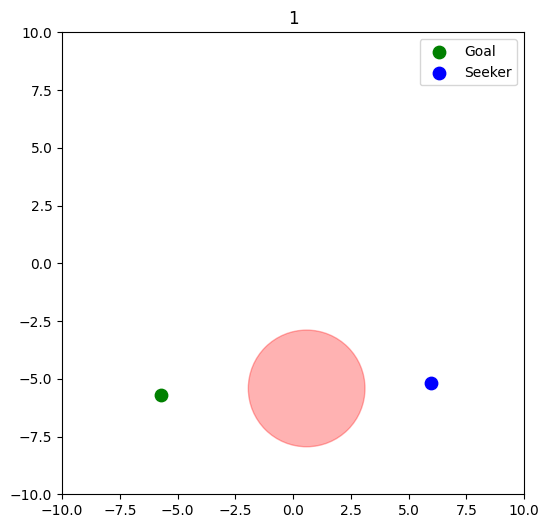

In [30]:
# number of obstacles this env actually has:
num_obstacles = (len(obs) - 4) // 3
# also just env._num_obstacles (?)

# reset real env
obs, info = env_real.reset()
plot_seeker_obs(obs, info, num_obstacles)

# randomize=True should give different positions over next two plots, but always same due to numpy rng seed

In [31]:
print(obs)

[ 5.98396753 -5.17789601 -5.72715059 -5.69871882  0.58691692 -5.41791639
  2.52576318]


In [32]:
# should be:
# [ 5.98396753 -5.17789601 -5.72715059 -5.69871882  0.58691692 -5.41791639
#   2.52576318]
obs == [5.98396753, -5.17789601, -5.72715059, -5.69871882, 0.58691692, -5.41791639, 2.52576318]

array([False, False, False, False, False, False, False])

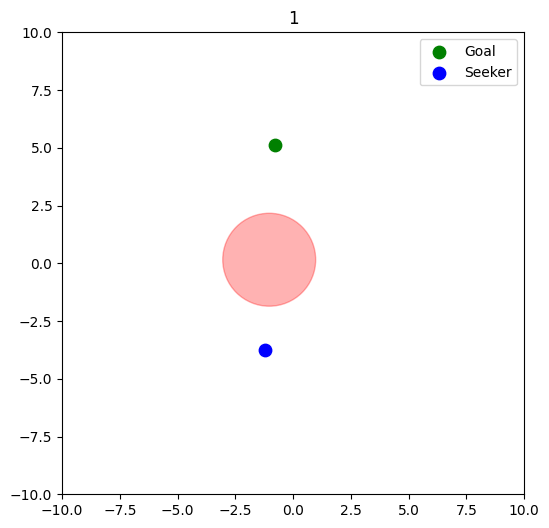

In [33]:
# reset real env -> different setup, but same different every time notebook is restarted ?
obs, info = env_real.reset()
plot_seeker_obs(obs, info, num_obstacles)

# randomize=True should give different positions over next two plots, but always same due to numpy rng seed

In [34]:
print(obs)

[-1.22498966 -3.75787548 -0.79074028  5.13316731 -1.03394827  0.15360326
  2.01160903]


In [35]:
# should be:
# [-1.22498966 -3.75787548 -0.79074028  5.13316731 -1.03394827  0.15360326
#   2.01160903]
obs == [-1.22498966, -3.75787548, -0.79074028, 5.13316731, -1.03394827, 0.15360326, 2.01160903]
# FAILS DUE TO ACTUALLY obs[0] (as an example) BEING -1.2249896644419165

array([False, False, False, False, False, False, False])

# create buffer, collect data, train, and log losses

## buffer and logging containers; schedules

In [36]:
# Buffer
replay = ReplayBufferHybrid(
    capacity=cfg.replay_buffer_capacity,
    obs_dim=obs_dim,
    action_dim=action_dim,
    K_max=32,
)

# Logging containers (easy to plot later)
logs = {
    "loss_total": [],
    "loss_value": [],
    "loss_policy": [],
    "loss_policy_distill": [],
    "loss_mu": [],
    "loss_log_std": [],
    "ep_return": [],
    "ep_length": [],
    "eval_return_mean": [],
    "eval_return_std": [],
    "eval_length_mean": [],
    "eval_length_succes": [],
    "eval_length_collision": [],
    "success_rate": [],
    "collision_rate": [],
    "max_step_rate": [],
    "iter_idx_eval": [],
}

In [37]:
## schedules (for later)

In [38]:
"""
# A simple schedule for gaussian regression weight λ
def lambda_gauss(iter_idx: int) -> float:
    # Example: off for first 10 iters, then ramp to 1.0 over 20 iters
    start = 10
    ramp = 20
    if iter_idx < start:
        return 0.0
    x = min(1.0, (iter_idx - start) / float(ramp))
    return float(x)  # ramps 0 -> 1


# Value target mixing schedule (optional)
def value_mix(iter_idx: int):
    # Example: start with MC a bit, then prefer MCTS
    # You can flip this if you want.
    w_mcts = 1.0
    w_mc = 0.0
    return w_mcts, w_mc
"""

'\n# A simple schedule for gaussian regression weight λ\ndef lambda_gauss(iter_idx: int) -> float:\n    # Example: off for first 10 iters, then ramp to 1.0 over 20 iters\n    start = 10\n    ramp = 20\n    if iter_idx < start:\n        return 0.0\n    x = min(1.0, (iter_idx - start) / float(ramp))\n    return float(x)  # ramps 0 -> 1\n\n\n# Value target mixing schedule (optional)\ndef value_mix(iter_idx: int):\n    # Example: start with MC a bit, then prefer MCTS\n    # You can flip this if you want.\n    w_mcts = 1.0\n    w_mc = 0.0\n    return w_mcts, w_mc\n'

# Training (outer loop)

In [39]:
import os, pickle

DEBUG_DIR = "debug_traces"
os.makedirs(DEBUG_DIR, exist_ok=True)

DEBUG_EVERY = 10          # e.g. every 50 training episodes
DEBUG_SEED = EVAL_SEEDS[-1]            # fixed seed for comparability
DEBUG_RECORD_EVERY = 1    # or 2/5 if trees are big
DEBUG_MAX_STEPS = 200

In [ ]:
import time

num_iters = 21

start_time = time.perf_counter()
print("start")
eval_data = []

MLE = True

episodes_collected = 0
episodes_to_collect = 100

episode_success = np.zeros(episodes_to_collect, dtype = bool)
episode_collision = np.zeros(episodes_to_collect, dtype = bool)
episode_max_step = np.zeros(episodes_to_collect)
episode_reward = np.full((episodes_to_collect, cfg.max_episode_steps),np.nan,dtype=float)
episode_z_mc = np.full((episodes_to_collect, cfg.max_episode_steps),np.nan,dtype=float)
episode_z_mcts = np.full((episodes_to_collect, cfg.max_episode_steps),np.nan,dtype=float)

for it in range(num_iters):
    now = time.perf_counter()
    print(f"main loop iter: {it}")
    print(f"time: {now-start_time}")
    last_time = now
    
    planner.set_training_iter(it)

    # ---- Collect ----
    ep_returns = []
    for _ in range(cfg.episodes_per_iter):
        stats, episode = collect_one_episode_hybrid(
            env_real=env_real,
            planner=planner,
            replay_buffer=replay,
            max_steps=cfg.max_episode_steps,
            gamma=cfg.gamma_mc,
            training=True,
        )
        if episodes_collected < episodes_to_collect:
                episode_success[episodes_collected] = stats["success"]
                episode_collision[episodes_collected] = stats["collision"]
                episode_max_step[episodes_collected] = stats["max_steps_reached"]
                for i, step in enumerate(episode):
                    episode_reward[episodes_collected, i] = step["reward"]
                    episode_z_mc[episodes_collected, i] = step["z_mc"]
                    episode_z_mcts[episodes_collected, i] = step["z_mcts"]
                episodes_collected += 1

        ep_returns.append(stats["return"])
        logs["ep_return"].append(stats["return"])
        logs["ep_length"].append(stats["length"])
    now = time.perf_counter()
    print("collect loop time:", now - last_time)
    last_time = now

    # ---- Train (baseline MLE/value regression) ----
    if len(replay) >= cfg.batch_size:
        for _ in range(cfg.train_steps_per_iter):
            batch = replay.sample(cfg.batch_size, device=device, rng=np.random.default_rng(SEED))
            if MLE:
                loss_dict = train_step_mle(
                    net=net,
                    optimizer=optimizer,
                    batch=batch,
                    w_value=cfg.value_loss_weight,
                    w_policy=cfg.policy_loss_weight,
                    grad_clip_norm=1.0,
                )
            else:
                loss_dict = train_step_mcts_distill(
                net=net,
                optimizer=optimizer,
                batch=batch,
                value_target="mc",   # teammate’s version
                w_value=cfg.value_loss_weight,
                w_policy=cfg.policy_loss_weight,
                grad_clip_norm=1.0,
                )
            for k, v in loss_dict.items():
                logs[k].append(v)
        now = time.perf_counter()
        print("train loop time:", now - last_time)
        last_time = now

    # ---- Eval (fixed seeds) ----
    if (it % cfg.eval_every) == 0:
        eval_stats = run_eval_episodes(
            env_eval=env_eval,
            planner=planner,
            seeds=EVAL_SEEDS,
            max_steps=cfg.max_episode_steps,
            goal_reward=env_eval._goal_reward,
            collision_reward=env_eval._collision_reward,
        )
        logs["iter_idx_eval"].append(it)
        logs["eval_return_mean"].append(eval_stats["eval_return_mean"])
        logs["eval_return_std"].append(eval_stats["eval_return_std"])
        logs["eval_length_mean"].append(eval_stats["eval_length_mean"])
        logs["success_rate"].append(eval_stats["success_rate"])
        logs["collision_rate"].append(eval_stats["collision_rate"])
        logs["eval_length_succes"].append(eval_stats["eval_length_mean_successes"])
        logs["eval_length_collision"].append(eval_stats["eval_length_mean_collisions"])
        logs["max_step_rate"].append(eval_stats["max_step_rate"])

        eval_data_this = []
        eval_data_this.append(eval_stats["returns"])
        eval_data_this.append(eval_stats["lengths"])
        eval_data_this.append(eval_stats["plot_data"])
        eval_data.append(eval_data_this)

        now = time.perf_counter()
        print("EVAL time:", now - last_time)
        last_time = now
        print(
            f"[Eval it={it}] "
            f"R={eval_stats['eval_return_mean']:.2f}±{eval_stats['eval_return_std']:.2f} "
            f"succ={eval_stats['success_rate']:.2f} "
            f"coll={eval_stats['collision_rate']:.2f} "
            f"max={eval_stats['max_step_rate']:.2f} "
            f"len_suc={eval_stats['eval_length_mean_successes']:.1f} "
            f"len_col={eval_stats['eval_length_mean_collisions']:.1f} "
        )
    
    # ---- DEBUG ----
    if (it % DEBUG_EVERY) == 0:
        dbg = run_debug_eval_episode(
            env_eval=env_eval,
            planner=planner,
            seed=DEBUG_SEED,
            max_steps=DEBUG_MAX_STEPS,
            #record_every=DEBUG_RECORD_EVERY,
        )
        dbg["train_episode"] = it  # handy metadata

        path = os.path.join(DEBUG_DIR, f"trace_ep{it:06d}_seed{DEBUG_SEED}.pkl")
        
        with open(path, "wb") as f:
            pickle.dump(dbg, f)
        
        now = time.perf_counter()
        print("DEBUG time:", now - last_time)
        last_time = now
    
        

    last_loss = logs["loss_total"][-1] if logs["loss_total"] else None
    print(
        f"Iter {it} | replay={len(replay)} | "
        f"train_return_mean={np.mean(ep_returns):.2f} | last_loss={last_loss}"
    )


start
main loop iter: 0
time: 0.011065900005633011
collect loop time: 19.97879139998986
train loop time: 0.5135626000119373
EVAL time: 44.319381799999974
[Eval it=0] R=2.57±131.72 succ=0.70 coll=0.00 max=0.30 len_suc=23.6 len_col=0.0 
DEBUG time: 1.5729405999882147
Iter 0 | replay=8268 | train_return_mean=52.40 | last_loss=0.011102570220828056
main loop iter: 1
time: 66.39661019999767


In [ ]:
break

# Debug Plots

## Plot for length episode and discount factors

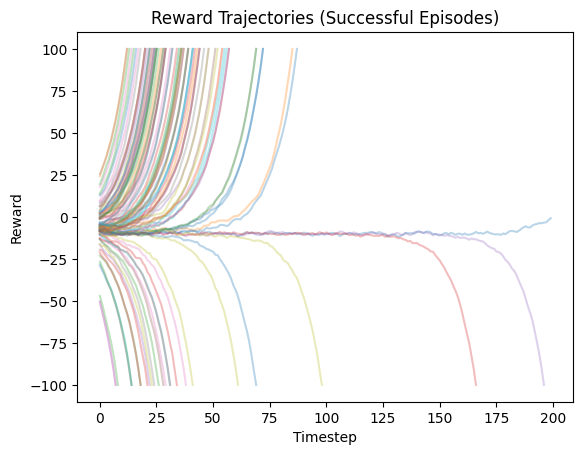

In [46]:
#print(sum(episode_max_step))
plot_episodes = np.logical_or(episode_success, np.logical_or(episode_max_step, episode_collision))
#plot_episodes = np.logical_or(episode_success,episode_collision)
#plot_episodes = episode_success
#plot_episodes = episode_collision
#plot_episodes= episode_max_step

plot_value = episode_z_mc

plt.figure()
for ep in np.where(plot_episodes)[0]:
    plt.plot(plot_value[ep], alpha=0.3)
plt.xlabel("Timestep")
plt.ylabel("Reward")
#plt.ylim(-2,1)
#plt.xlim(0,40)
plt.title("Reward Trajectories (Successful Episodes)")
plt.show()

## load debug pickle data

In [30]:
with open("debug_traces/trace_ep000010_seed1009.pkl", "rb") as f:
    dbg = pickle.load(f)

## Plot for MCTS tree

In [ ]:
from graphviz import Digraph

def mcts_to_graphviz(root, *, depth_limit=None, max_nodes=2000, highlight_child_idx=None):
    """
    Build a Graphviz Digraph for an MCTS tree rooted at `root`.

    depth_limit: None for full depth, or int to cap depth
    max_nodes: stop after this many nodes (safety)
    highlight_child_idx: if given, highlight that root child edge/node
    """
    dot = Digraph(comment="MCTS Tree")
    dot.attr("node", shape="box", fontsize="10")
    dot.attr("edge", fontsize="9")

    # Assign stable ids
    node_id = {}
    next_id = 0

    def get_id(node):
        nonlocal next_id
        k = id(node)
        if k not in node_id:
            node_id[k] = f"n{next_id}"
            next_id += 1
        return node_id[k]

    # BFS/DFS traversal
    stack = [(root, 0)]
    seen = set()
    created = 0

    while stack:
        node, depth = stack.pop()
        nid = get_id(node)

        if nid in seen:
            continue
        seen.add(nid)

        # Stop conditions
        if created >= max_nodes:
            break
        if depth_limit is not None and depth > depth_limit:
            continue

        # Node label
        N = getattr(node, "N", 0)
        v = getattr(node, "v", None)
        is_term = getattr(node, "is_terminal", False)
        term_v = getattr(node, "terminal_value", None)

        label = f"N={N}"
        if v is not None:
            label += f"\\nv={float(v):.3f}"
        if is_term:
            label += "\\nTERMINAL"
            if term_v is not None:
                label += f"\\nTv={float(term_v):.3f}"

        # Style terminal nodes
        if is_term:
            dot.node(nid, label=label, style="filled", fillcolor="lightgray")
        else:
            dot.node(nid, label=label)

        created += 1

        # Children edges
        children = getattr(node, "children", [])
        for i, ch in enumerate(children):
            child = ch.child_node
            cid = get_id(child)

            # Edge label includes stats
            a = np.array(ch.action).tolist()
            edge_label = (
                f"a={a}"
                f"\\nr={float(ch.r_sa):.3f}"
                f"\\nN={int(ch.N_sa)}"
                f"\\nQ={float(ch.Q_sa):.3f}"
                f"\\nP={float(ch.P_sa):.3g}"
            )

            # Highlight chosen root child
            if node is root and highlight_child_idx is not None and i == int(highlight_child_idx):
                dot.edge(nid, cid, label=edge_label, penwidth="3")
                dot.node(cid, style="filled", fillcolor="palegreen")
            else:
                dot.edge(nid, cid, label=edge_label)

            # Continue traversal
            stack.append((child, depth + 1))

    if created >= max_nodes:
        # Add a note node
        dot.node("TRUNC", f"TRUNCATED at max_nodes={max_nodes}", style="filled", fillcolor="orange")
    return dot

In [ ]:
from ipywidgets import interact, IntSlider

def inspect_debug_trace(dbg, *, depth_limit=3, max_nodes=2000):
    states = dbg["states"]
    roots = dbg["roots"]
    chosen = dbg["chosen_idx"]
    info = dbg["info"]
    record_every = max(1, int(dbg.get("record_every", 1)))  # optional if you store it

    def view(k):
        # k indexes into recorded roots
        env_t = k * record_every

        # state plot
        plot_seeker_obs(states[env_t], info, title=f"Seed={dbg['seed']} | train_ep={dbg.get('train_episode')} | t={env_t}")

        # tree plot
        dot = mcts_to_graphviz(
            roots[k],
            depth_limit=depth_limit,
            max_nodes=max_nodes,
            highlight_child_idx=chosen[k],
        )
        return dot

    interact(view, k=IntSlider(min=0, max=len(roots)-1, step=1, value=0))


In [ ]:
inspect_debug_trace(dbg, depth_limit=10, max_nodes=2000)

## Plot for MCTS tree (2)

In [23]:
def collect_tree_edges(root, depth_limit=None, max_nodes=5000):
    """
    Traverse the tree and collect (parent_node, child_node, child_edge, depth_child).
    """
    edges = []
    stack = [(root, 0)]
    seen = set()
    node_count = 0

    while stack:
        node, depth = stack.pop()
        node_id = id(node)
        if node_id in seen:
            continue
        seen.add(node_id)
        node_count += 1
        if node_count > max_nodes:
            break

        if depth_limit is not None and depth >= depth_limit:
            continue

        for ch in getattr(node, "children", []):
            child = ch.child_node
            edges.append((node, child, ch, depth + 1))
            stack.append((child, depth + 1))

    return edges


def plot_mcts_tree_xy(
    root,
    info,
    chosen_child_idx=None,
    depth_limit=6,
    max_nodes=4000,
    show_edge_text=False,
    highlight_subtree=False,
    title=None,
):
    """
    Visualize an MCTS tree in environment XY coordinates.
    - chosen_child_idx highlights the root->child edge that planner.act picked.
    - highlight_subtree: if True, highlight the entire subtree under chosen child.
    """
    root_obs = root.state
    agent0, goal, obstacles = decode_obs(root_obs)
    L = info.get("boundary_size", 10)

    edges = collect_tree_edges(root, depth_limit=depth_limit, max_nodes=max_nodes)

    # Precompute positions
    def pos(node):
        a, _, _ = decode_obs(node.state)
        return float(a[0]), float(a[1])

    # Determine which nodes/edges are in the chosen subtree (optional)
    chosen_subtree_nodes = set()
    chosen_child_node = None
    if chosen_child_idx is not None and 0 <= chosen_child_idx < len(root.children):
        chosen_child_node = root.children[int(chosen_child_idx)].child_node

    if highlight_subtree and chosen_child_node is not None:
        stack = [chosen_child_node]
        while stack:
            n = stack.pop()
            if id(n) in chosen_subtree_nodes:
                continue
            chosen_subtree_nodes.add(id(n))
            for ch in getattr(n, "children", []):
                stack.append(ch.child_node)

    fig, ax = plt.subplots(figsize=(7, 7))

    # Obstacles
    for (ox, oy, r) in obstacles:
        ax.add_patch(plt.Circle((ox, oy), r, alpha=0.3))
    # Goal / Agent
    ax.scatter(goal[0], goal[1], s=140, marker="*", label="Goal", zorder=5)
    ax.scatter(agent0[0], agent0[1], s=90, label="Root state", zorder=6)

    # Draw edges + nodes
    # Draw non-highlight edges first
    for parent, child, ch, d in edges:
        x0, y0 = pos(parent)
        x1, y1 = pos(child)

        is_chosen_edge = (parent is root and chosen_child_node is child)
        in_chosen_subtree = (highlight_subtree and id(child) in chosen_subtree_nodes)

        # Edge style
        if is_chosen_edge:
            lw = 3.0
            alpha = 0.9
        elif in_chosen_subtree:
            lw = 2.0
            alpha = 0.6
        else:
            lw = 1.0
            alpha = 0.25

        ax.plot([x0, x1], [y0, y1], linewidth=lw, alpha=alpha, zorder=1)

        if show_edge_text:
            mx, my = (x0 + x1) / 2, (y0 + y1) / 2
            ax.text(
                mx, my,
                f"N={ch.N_sa}\nQ={ch.Q_sa:.2f}\nP={ch.P_sa:.2g}",
                fontsize=7,
                alpha=0.8,
                ha="center", va="center"
            )

    # Scatter nodes (child endpoints)
    xs, ys, sizes, alphas = [], [], [], []
    xs_hi, ys_hi = [], []
    for parent, child, ch, d in edges:
        x1, y1 = pos(child)
        xs.append(x1); ys.append(y1)
        sizes.append(18 + 6 * min(d, 6))
        alphas.append(0.15 + 0.10 * (depth_limit - d) if depth_limit else 0.2)

        if chosen_child_node is child:
            xs_hi.append(x1); ys_hi.append(y1)

    ax.scatter(xs, ys, s=sizes, alpha=0.35, label="Tree nodes", zorder=3)
    if xs_hi:
        ax.scatter(xs_hi, ys_hi, s=140, alpha=0.95, label="Chosen child", zorder=7)

    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="upper right")

    if title:
        ax.set_title(title)

    # Print root-child stats as a small table-like text
    if len(getattr(root, "children", [])) > 0:
        lines = ["Root children (sorted by N):"]
        rows = []
        for i, ch in enumerate(root.children):
            rows.append((i, ch.N_sa, ch.Q_sa, ch.P_sa, ch.r_sa, np.array(ch.action)))
        rows.sort(key=lambda r: r[1], reverse=True)

        for (i, N, Q, P, r, a) in rows[:12]:  # top 12
            star = " <= chosen" if (chosen_child_idx is not None and i == int(chosen_child_idx)) else ""
            lines.append(f"[{i}] N={N:4d}  Q={Q:7.3f}  P={P:8.3g}  r={r:7.3f}  a={a}{star}")

        # place text under plot
        fig.text(0.02, 0.02, "\n".join(lines), fontsize=9, va="bottom")

    plt.show()
    return fig


In [24]:
from ipywidgets import interact, IntSlider

def inspect_debug_trace_xy(dbg, *, depth_limit=6, max_nodes=4000, show_edge_text=False, highlight_subtree=False):
    roots = dbg["roots"]
    chosen = dbg["chosen_idx"]
    info = dbg["info"]
    record_every = max(1, int(dbg.get("record_every", 1)))

    def view(k):
        env_t = k * record_every
        plot_mcts_tree_xy(
            roots[k],
            info,
            chosen_child_idx=chosen[k] if k < len(chosen) else None,
            depth_limit=depth_limit,
            max_nodes=max_nodes,
            show_edge_text=show_edge_text,
            highlight_subtree=highlight_subtree,
            title=f"Seed={dbg['seed']} | train_ep={dbg.get('train_episode')} | t={env_t}"
        )

    interact(view, k=IntSlider(min=0, max=len(roots)-1, step=1, value=0))


In [33]:
#dbg = run_debug_eval_episode(env_eval=env_eval, planner=planner, seed=0, max_steps=200, record_every=1)
#dbg["record_every"] = 1
#dbg["train_episode"] = 500

inspect_debug_trace_xy(dbg, depth_limit=3, max_nodes=4000, highlight_subtree=True)

interactive(children=(IntSlider(value=0, description='k', max=17), Output()), _dom_classes=('widget-interact',…

## Plot for MCTS tree 3

In [ ]:
dbg = run_debug_eval_episode(
            env_eval=env_eval,
            planner=planner,
            seed=DEBUG_SEED,
            max_steps=DEBUG_MAX_STEPS,
            record_every=DEBUG_RECORD_EVERY,
        )

In [35]:
dbg.keys()

dict_keys(['seed', 'info', 'states', 'roots', 'chosen_idx', 'actions', 'record_every', 'train_episode'])

In [39]:
len(dbg["states"])

19

In [38]:
len(dbg["roots"])

18

In [46]:
dbg["roots"][1]

MCTSNode(state=array([-6.39660693,  1.8079048 ,  2.72556699,  5.93535247, -2.641483  ,
        3.38869486,  1.02797556]), parent=None, parent_action=None, N=200, children=[Child(action=array([0.27839294, 0.8099003 ], dtype=float32), child_node=MCTSNode(state=array([-6.11821399,  2.61780507,  2.72556699,  5.93535247, -2.641483  ,
        3.38869486,  1.02797556]), parent=..., parent_action=array([0.27839294, 0.8099003 ], dtype=float32), N=15, children=[Child(action=array([ 0.30743608, -0.6171967 ], dtype=float32), child_node=MCTSNode(state=array([-5.81077792,  2.00060839,  2.72556699,  5.93535247, -2.641483  ,
        3.38869486,  1.02797556]), parent=..., parent_action=array([ 0.30743608, -0.6171967 ], dtype=float32), N=1, children=[Child(action=array([-0.28436315,  0.44861603], dtype=float32), child_node=MCTSNode(state=array([-6.09514106,  2.44922441,  2.72556699,  5.93535247, -2.641483  ,
        3.38869486,  1.02797556]), parent=..., parent_action=array([-0.28436315,  0.44861603], d

## Plot for seeker trajectory

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def plot_seeker_trajectory(states, title=None, cmap="viridis",
                           show_line=True, show_points=True, annotate=False):
    """
    states: list/iterable of obs vectors (each encodes agent, goal, obstacles)
    info: dict with boundary_size etc.
    """
    if len(states) == 0:
        return

    # Use first state for static elements (goal/obstacles/boundary)
    agent0, goal, obstacles = decode_obs(states[0])
    L = 10

    # Extract agent positions over time
    agents = np.array([decode_obs(s)[0] for s in states])  # shape (T, 2)
    T = len(agents)
    t = np.arange(T)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Obstacles
    for (ox, oy, r) in obstacles:
        ax.add_patch(plt.Circle((ox, oy), r, color="red", alpha=0.3))

    # Goal
    ax.scatter(goal[0], goal[1], color="green", s=120, marker="*", label="Goal", zorder=3)

    # Trajectory
    if show_line:
        ax.plot(agents[:, 0], agents[:, 1], linewidth=2, alpha=0.7, label="Path", zorder=2)

    if show_points:
        sc = ax.scatter(
            agents[:, 0], agents[:, 1],
            c=t, cmap=cmap, s=35, zorder=4
        )
        plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label="Step")

    # Start / End markers
    ax.scatter(agents[0, 0], agents[0, 1], color="cyan", s=90, label="Start", zorder=5)
    ax.scatter(agents[-1, 0], agents[-1, 1], color="black", s=90, label="End", zorder=5)

    if annotate:
        for i, (x, y) in enumerate(agents):
            ax.text(x, y, str(i), fontsize=8)

    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="upper right")
    if title:
        ax.set_title(title)
    plt.show()


In [ ]:
evaluation_iter_data = eval_data[12]
STATES = 2
for SEED in range(10):
    plot_seeker_trajectory(evaluation_iter_data[STATES][SEED]["states"], title="Seeker rollout", cmap="plasma")
    print("return: ", evaluation_iter_data[0][SEED])
    print("steps: ", evaluation_iter_data[1][SEED])

In [ ]:
import pickle

size_bytes = len(pickle.dumps(eval_data, protocol=pickle.HIGHEST_PROTOCOL))
print(size_bytes)

with open("evaldata_terminal0_batchScaleTrain_warmstart_warmnode_l2diversity.pkl", "wb") as f:
    pickle.dump(eval_data, f, protocol=pickle.HIGHEST_PROTOCOL)

# Training Plots

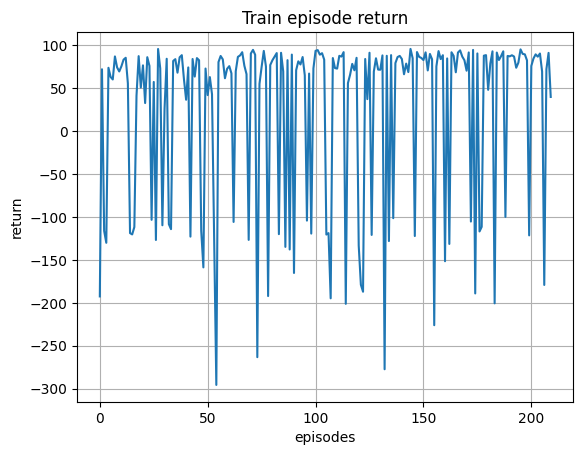

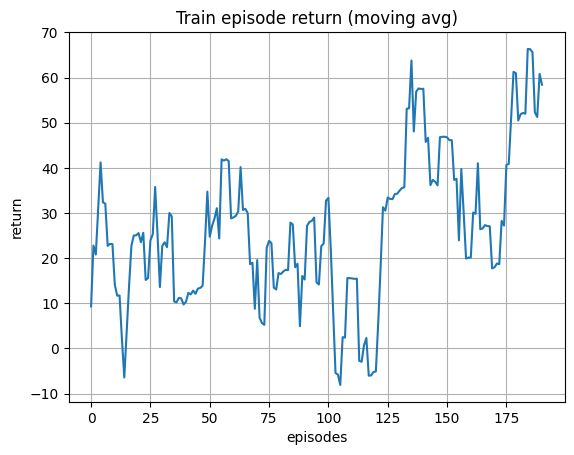

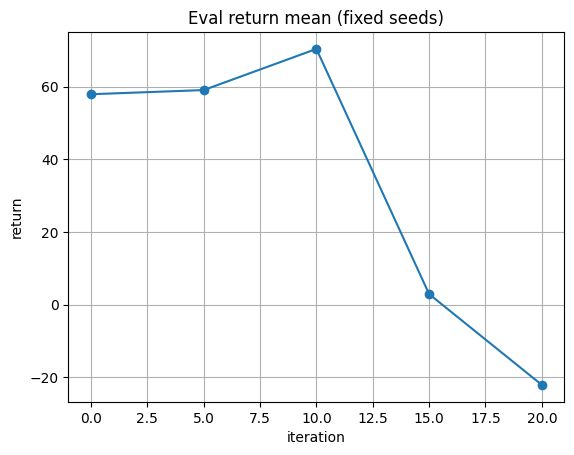

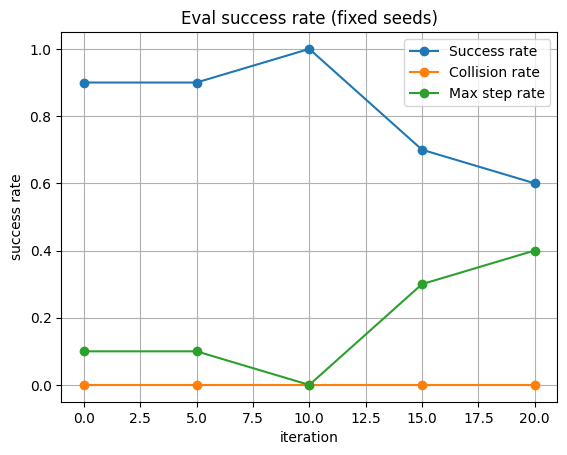

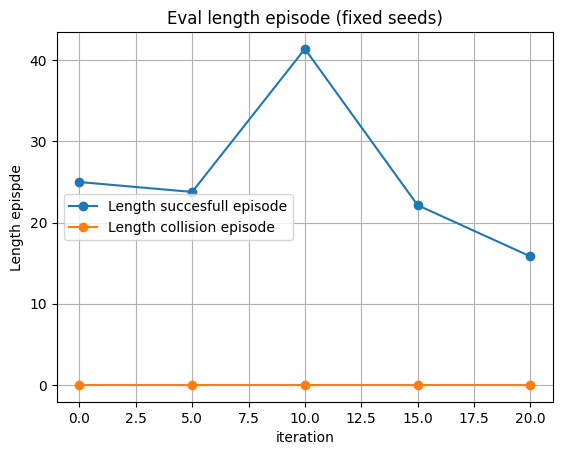

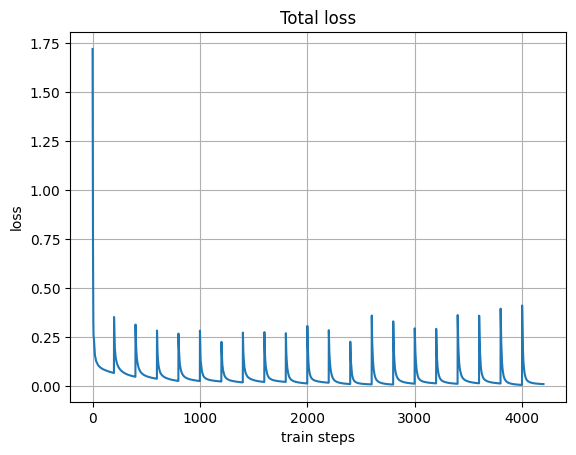

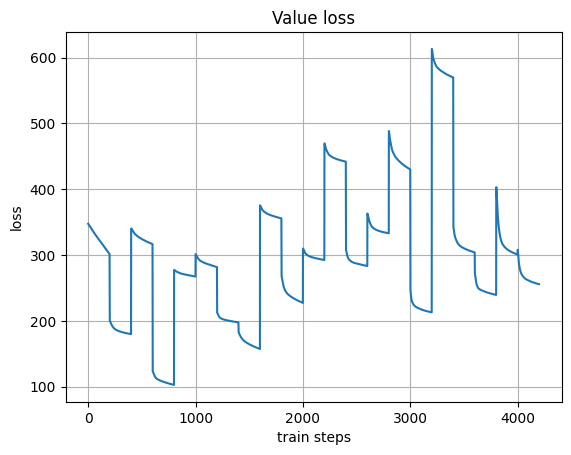

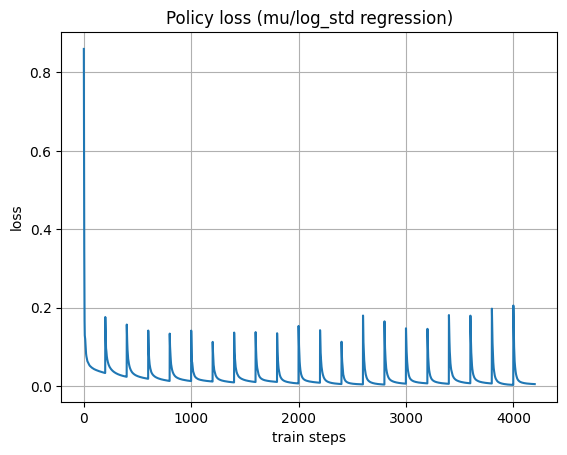

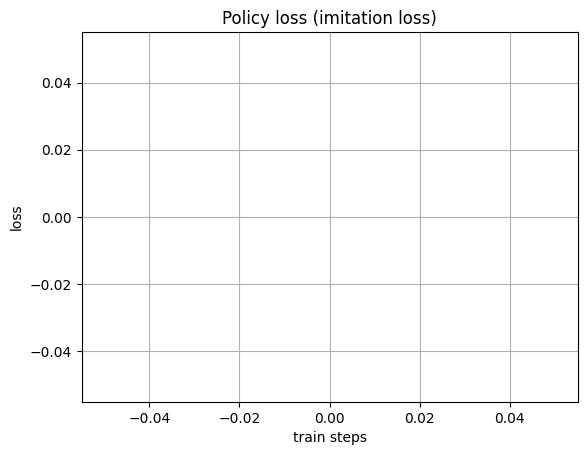

In [48]:
def moving_avg(x, w=20):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

# Train return moving average
plt.figure()
plt.plot(logs["ep_return"])
plt.title("Train episode return")
plt.xlabel("episodes")
plt.ylabel("return")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(moving_avg(logs["ep_return"], w=20))
plt.title("Train episode return (moving avg)")
plt.xlabel("episodes")
plt.ylabel("return")
plt.grid(True)
plt.show()

# Eval return mean
if logs["eval_return_mean"]:
    #print(logs["eval_return_mean"])
    plt.figure()
    plt.plot(logs["iter_idx_eval"], logs["eval_return_mean"], marker="o")
    plt.title("Eval return mean (fixed seeds)")
    plt.xlabel("iteration")
    plt.ylabel("return")
    plt.grid(True)
    plt.show()

# Eval success rate
if logs["success_rate"]:
    #print(logs["success_rate"])
    plt.figure()
    plt.plot(logs["iter_idx_eval"], logs["success_rate"], marker="o", label="Success rate")
    plt.plot(logs["iter_idx_eval"], logs["collision_rate"], marker="o", label="Collision rate")
    plt.plot(logs["iter_idx_eval"], logs["max_step_rate"], marker="o", label="Max step rate")
    plt.title("Eval success rate (fixed seeds)")
    plt.xlabel("iteration")
    plt.ylabel("success rate")
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(True)
    plt.show()

if logs["eval_length_succes"]:
    plt.figure()
    plt.plot(logs["iter_idx_eval"], logs["eval_length_succes"], marker="o", label = "Length succesfull episode")
    plt.plot(logs["iter_idx_eval"], logs["eval_length_collision"], marker="o", label = "Length collision episode")
    plt.title("Eval length episode (fixed seeds)")
    plt.xlabel("iteration")
    plt.ylabel("Length epispde")
    plt.legend()
    plt.grid(True)
    plt.show()

# Losses
if logs["loss_total"]:
    plt.figure()
    plt.plot(logs["loss_total"])
    plt.title("Total loss")
    plt.xlabel("train steps")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(logs["loss_value"])
    plt.title("Value loss")
    plt.xlabel("train steps")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(logs["loss_policy"])
    plt.title("Policy loss (mu/log_std regression)")
    plt.xlabel("train steps")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(logs["loss_policy_distill"])
    plt.title("Policy loss (imitation loss)")
    plt.xlabel("train steps")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()
    

# Other stuff

In [ ]:
"""
num_iters = 30  # start with 30; increase later

# Add eval logs
logs.setdefault("eval_return_mean", [])
logs.setdefault("eval_return_std", [])
logs.setdefault("eval_length_mean", [])
logs.setdefault("success_rate", [])
logs.setdefault("collision_rate", [])
logs.setdefault("iter_idx_eval", [])

# Simple schedules: start clean
def lambda_gauss(iter_idx: int) -> float:
    return 0.0  # baseline: off

def value_mix(iter_idx: int):
    return 1.0, 0.0  # baseline: use z_mcts only


for it in range(num_iters):
    # tell planner what outer iteration we are in
    planner.set_training_iter(it)

    # --- Collect episodes ---
    ep_returns = []
    ep_lengths = []
    for _ in range(cfg.episodes_per_iter):
        stats, _ = collect_one_episode_hybrid(
            env_real=env_real,
            planner=planner,
            replay_buffer=replay,
            max_steps=cfg.max_episode_steps,
            gamma=cfg.gamma,
            training=True,
        )
        ep_returns.append(stats["return"])
        ep_lengths.append(stats["length"])
        logs["ep_return"].append(stats["return"])
        logs["ep_length"].append(stats["length"])

    # --- Train ---
    if len(replay) >= cfg.batch_size:
        w_mcts, w_mc = value_mix(it)
        w_gauss = lambda_gauss(it)

        for _ in range(cfg.train_steps_per_iter):
            batch = replay.sample(cfg.batch_size, device=device, rng=np.random.default_rng(SEED))
            loss_dict = train_step_hybrid(
                net=net,
                optimizer=optimizer,
                batch=batch,
                w_value_mcts=w_mcts * cfg.value_loss_weight,
                w_value_mc=w_mc * cfg.value_loss_weight,
                w_policy_imitation=cfg.policy_loss_weight,
                w_gaussian_reg=w_gauss * cfg.policy_loss_weight,
                grad_clip_norm=1.0,
            )
            for k, v in loss_dict.items():
                logs[k].append(v)

    # --- Eval (fixed seeds) ---
    if (it % cfg.eval_every) == 0:
        eval_stats = run_eval_episodes(
            env_eval=env_eval,
            planner=planner,
            seeds=EVAL_SEEDS,
            max_steps=cfg.max_episode_steps,
            goal_reward=env_eval._goal_reward,
            collision_reward=env_eval._collision_reward,
        )
        logs["iter_idx_eval"].append(it)
        logs["eval_return_mean"].append(eval_stats["eval_return_mean"])
        logs["eval_return_std"].append(eval_stats["eval_return_std"])
        logs["eval_length_mean"].append(eval_stats["eval_length_mean"])
        logs["success_rate"].append(eval_stats["success_rate"])
        logs["collision_rate"].append(eval_stats["collision_rate"])

        print(
            f"[Eval it={it}] "
            f"R={eval_stats['eval_return_mean']:.2f}±{eval_stats['eval_return_std']:.2f} "
            f"len={eval_stats['eval_length_mean']:.1f} "
            f"succ={eval_stats['success_rate']:.2f} "
            f"coll={eval_stats['collision_rate']:.2f}"
        )

    last_loss = logs["loss_total"][-1] if logs["loss_total"] else None
    print(
        f"Iter {it} | replay={len(replay)} | "
        f"train_return_mean={np.mean(ep_returns):.2f} | "
        f"last_loss={last_loss}"
    )
"""